In [1]:
import numpy as np
dt = 1.0/30
g = 9.8
L = 0.4
import matplotlib.pyplot as plt
%matplotlib inline

# LQR
What is a LQR (Linear Quadratic Regulator? It's a way to derive feedback system from the equations of motion.
Optimizing quadratic functions leads to a linear problem because the derivative of a quadratic term is a linear term.
So the LQR is a formulation of a control problem that uses a quadratic cost function and evolves under linear dynamics.
Basically the only math that mankind can rip to shreds is linear algebra (matrix shit). We can solve Matrix equations (and by that I mean we can get computers to solve) like nobodies business.
Hence it often behooves us to find a way to formulate any problem in engineering or physics in some kind of linear framework.
You can find more here:
https://studywolf.wordpress.com/2016/02/03/the-iterative-linear-quadratic-regulator-method/

In the code we are following the conventions setup in
https://katefvision.github.io/katefSlides/RECITATIONtrajectoryoptimization_katef.pdf

### Defining the Control Problem

The formulation of a control problem is one in which we are trying a cost function C(x,u) that may be a sum over many time steps, where x is the state vector (may an often will include velocities. Anything we need to be able to predict the next state) and u is the control vector (some set of numbers we get to decide like voltage to a motor or something)
It just so happens that this combo is exactly solvable in terms of matrix operations.

Let's define $z=(x,u)$ as a vector that is made out of stacked state and action vectors (the direct sum of their spaces)
We want to find the solution to the problem $\min \sum_{t=0}^{N-1} (z_{t}^{T}C_tz_t + c_t^{T}z_t)$ such that $A_tz_{t}-z_{t+1}=0$
Now, one way of solving the problem would be to make just one big matrix with a dimensionality proportional to the number of time steps we're looking ahead, and maybe in fact that is smart since python is slow and putting everything into numpy might be both easier to program and faster. The constraint that the steps are connected by the dynamics can be implemented by adding in lagrange multipliers at every time step. This still maintains the quadratic nature of the minimization.
$\min \sum_{t=0}^{N-1} (z^{T}Cz + c^{T}z) +\sum_{t=0}^{N-2} \lambda_t^{T} (Az_{t}-z_{t+1})$
But let's take a different approach

### A Correspondence to Reinforcement Learning
It is very interesting that there is a method to solve this problem that mirrors the methodology found in reinforcement learning.
If we had a way of evaluating the value of being in a state and we new which state and action takes us to, we should just take the action that puts us in the highest valued state.
That requires lookahead though. We need to know what state our actions take us to.
Hence there is a clever trick, the Q function. The Q function takes the current state and an action as parameters and outputs the expected return of that combo. With this, we don't need to lookahead using dynamics in order to figure out which is the best action, we can just search the different actions.

In the LQR, the V and Q functions are quadratic. This means they can be parametrized by a Matrix term and a vector term $Q_t(x,a)=z^{T} Q_t z + q_t^{T} z $

The solution starts as the end. At the end we already know the Q function. It is just the cost function, since there is no future cost to consider.
We can minimize with respect to the control u to get the value function V. The solution to this minimaztion is a way to write the control in terms of x, giving us a control matrix K. $u_t=Kx_t+k$ Substituting this expession into the Q expression removes the variable u, giving us the value function V. Then we can backup one step using the dynamics to get the previous Q function in terms of the current V function.

What is in particular good about this method is the sequence of K matrices we get, which are useful for a feedback system.

Now many systems are in fact not quadratic cost or linear dynamics. Nevertheless we can leverage our abilities to make an iterative solver for a linearization of the nonlinear stuff.
The mapping from the nonlinear problem is a touch confusing because the new variables x' and u' are the displacement from the current estimated trajectory, not the entire trajectory itself. First, this means the dynamics f vector is going to be zero since a zero displacement should evolve into a zero dispacelemtn. The c vector is also no longer the original. It is the gradient of cost function and in general will be a function of the actual path x,u. 

It is important to note that the backward pass is done on the linearized dynamics of $\delta x = x-x_0 $. where $x_0$ is the actual path evaluted in the forward pass. Then we run the thing forward using the updated control sequence $u_0 + \delta u =u_0+ K_t x + k$


### Dynamical Details
I used split step integration (called Verlet or leapfrog) where I alternate updating the velocity and position. This scheme tends to be more stable and more energy conserving. When I updated them together at first using a straightforward euler step, the energy in the pendulum exploded. Ruh Roh. Unfortunately the way I did this makes every two steps correspond to a single time step.
There is almost certainly something to using ODEint rather than my own custom rolled integration routine. But then I can't use odeint for the backwards pass unless I used a finite difference to find the linearized dynamics. Which is actually a totally reaosnable approach btw. I made my bed.


We're using cartpole as an example since the whole reason this code was written was to control a cartpole. The idea is you have a cart with a hinged pole that you need to balance by pushing the cart back and forth.

The equations of motion for a cartpole are
$\frac{d^2\theta}{dt^2}=\frac{3}{2L}(a \sin(\theta)-g\cos(\theta))$
I got this out of a Lagrangian. Don't worry about it. The point is by accelerating the cart an amount a, you can apply a torque to the pole. The $\sin$ factor means you get no torque if the pole is horizontal and maximum torque if the pole is vertical. The standing upright position is the place where g has the least effect and a has the most effect, which is nice.
The linearization around this path is given by
$\frac{d^2\delta\theta}{dt^2}=\frac{3}{2L}(a \delta\theta\cos(\theta)+\delta a \sin(\theta) +g\delta\theta\sin(\theta))$
It is these equations that generate the F needed by LQR


To make C mostly have comparable units we add factors corresponding to the important physical scales. $\sqrt(L/g)$ is the time it takes for a small perturbation from equilibrium to roughly double. $g$ is the gravitational acceleration that any cart acceleration is going to be compared to.

Without further ado, big hunks of monolithic badly written code!

In [2]:
def F(theta,a, t): #Linearized dynamics matrix
    if t%2 == 0:
        return np.array([[1,dt,0],
                     [0, 1, 0]])
    else:
        return np.array([[1,0,0],
                     [ 3/2/L * (a * np.cos(theta[0]) + g * np.sin(theta[0])) * dt, 1,
                     (3 / 2 * np.sin(theta[0]) / L ) * dt]])

def step(theta, a, t): #One time step. One Even steps update theta on odd steps update derivative of theta
    if t%2==0:
        theta1 = theta[0] + theta[1]*dt 
        dtheta = theta[1]
    else:
        theta1 = theta[0]    
        dtheta = theta[1] +  3/2/L * (a * np.sin(theta1) - g * np.cos(theta1)) * dt
    return np.array( [theta1,dtheta])
def f(xu): 
    #Offset of dynamics is always zero in iLQR. The system always will follow it's original trajectory if
    # \delta x is zero. 
    return np.zeros(2)

def C(): #Cost Matrix
    return np.array([[1,0,0],
                     [0,0.01 * np.sqrt(L/g),0],
                     [0,0,0.01 / g]])
def c(theta,a): #Cost vector. It is the first derivative of the cost function evaluated at the current trajectory
    return C() @ np.array([theta[0] - 1 * np.pi/2, theta[1], a])

# A set of routines for packing and unpacking the state and control blocks of matrices and vectors.
def xxBlock(R):
    return R[0:2,0:2]
def xuBlock(R):
    return R[0:2,2].reshape((2,1))
def uxBlock(R):
    return R[2,0:2].reshape((1,2))
def uuBlock(R):
    return R[2,2].reshape((1,1))
def Block(xx,xu,ux,uu):
    return np.block([[xx,xu],[ux,uu]])
    R = np.zeros((3,3))
    R[2,2] = uu
    R[2,0:2] = ux
    R[0:2,2] = xu
    R[0:2,0:2] = xx
    return R
def xBlock(v):
    return v[0:2]
def uBlock(v):
    return v[2].reshape((1))
def Stack(x,u):
    v = np.zeros(3)
    v[:2] = x
    v[2] = u
    return v 
    

In [3]:

#N is the number of steps to lookahead
# ass holds the accelerations. as is a python keyword, that's why I made it ass. Also it is funny.
#thetas hold time 0...N
#ass hold time 0...N
def forward(theta0, Ks, ks, thetas0, ass0, N):
    thetas = []
    ass = []
    thetas.append(theta0)
    theta = np.copy(theta0)
    for i in range(N):
        a = ass0[i] + Ks[i]@(theta-thetas0[i]) + ks[i]
        theta = step(theta, a, i)
        thetas.append(theta)
        ass.append(a)
    a = ass0[i] + Ks[i]@(theta-thetas0[i]) + ks[i]
    ass.append(a)
    return thetas, ass

def backward(thetas, ass0, N):
    #This is a transcription of the Stanford slides basically. See link way above.
    Q =  C() #For the final step t=N, The Q matrix is just the Cost Matrix
    q = c(thetas[-1],ass0[-1]) #likewise
    K = - np.linalg.inv(uuBlock(Q)) @ uxBlock(Q)
    k = - np.linalg.inv(uuBlock(Q)) @ uBlock(q)
    V = xxBlock(Q) + xuBlock(Q) @ K + K.T @ uxBlock(Q) + K.T @ uuBlock(Q) @ K
    v = xBlock(q) + xuBlock(Q) @ k + K.T @ uBlock(q) + K.T @ uuBlock(Q) @ k
    Ks = [] #We'll collect up and store the control matrices (matrices that give good linear feedback), u=Kx+k
    ks = [] 
    for i in reversed(range(N)): # counts time N-1 down to 0
        Ft = F(thetas[i],ass0[i],i) #Dynamics matrix x_{t+1} = F @ (x_t,u_t) + f
        ft = np.zeros(2) #step(thetas[i], ass0[i])
        #print(ft)
        Q = C() + Ft.T @ V @ Ft # comes from C + x_t+1 @ V @x_t+1, 
        q = c(thetas[i],ass0[i]) + Ft.T @ V @ ft + Ft.T @ v
        #print(Q)
        #print(uuBlock(Q))
        K = - np.linalg.inv(uuBlock(Q)) @ uxBlock(Q) #minimizing over u.
        k = - np.linalg.inv(uuBlock(Q)) @ uBlock(q)
        V = xxBlock(Q) + xuBlock(Q) @ K + K.T @ uxBlock(Q) + K.T @ uuBlock(Q) @ K #substituting u = Kx+k into Q
        v = xBlock(q) + xuBlock(Q) @ k + K.T @ uBlock(q) + K.T @ uuBlock(Q) @ k
        Ks.append(K)
        ks.append(k)
    return list(reversed(Ks)), list(reversed(ks))

#Takes an initial value of theta, iterations of backward forward passes and perhaps an initialization of control.
def iLQR(theta0, iters=30, N=20, Ks=None, ks=None):
    if not Ks:
        Ks = np.zeros((N,1,2))
    if not ks:
        ks = np.zeros((N,1))
    ass = np.zeros(N)
    thetas=np.zeros((N,2))
    for i in range(iters):
        thetas, ass = forward(theta0, Ks, ks, thetas, ass, N)
        assert len(thetas) == len(ass)
        
        Ks, ks = backward(thetas, ass, N)
    return thetas, ass, Ks, ks
    

        

If we set the pendulum at the (unstable) equilibrium position, it should not require much intervention. Sanity check.

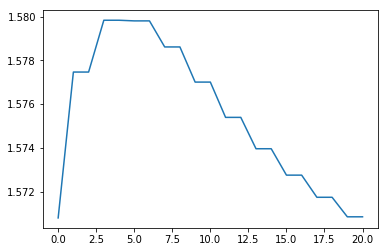

In [13]:
thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2,0.2]), iters=10000)
plt.plot(np.array(thetas)[:,0])
#print(thetas)

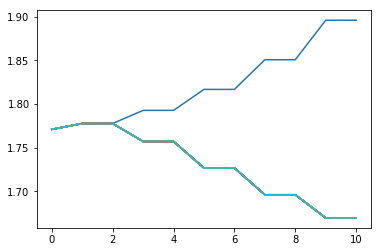

In [5]:
#Deomnstrating the convergence properties in terms of iLQR iterations
for i in range(20):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=10*i+1,N=10)
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

Uncontrolled evolution

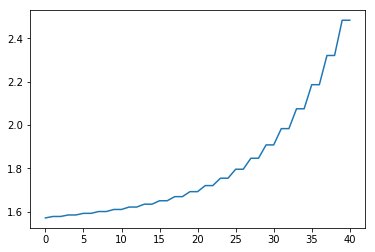

In [6]:
N=40
theta0 = np.array([np.pi/2,0.2])
Ks = np.zeros((N,1,2))
ks = np.zeros((N,1))
ass = np.zeros(N)
thetas=np.zeros((N,2))
thetas, ass = forward(theta0, Ks, ks, thetas, ass, N)
plt.plot(np.array(thetas)[:,0])

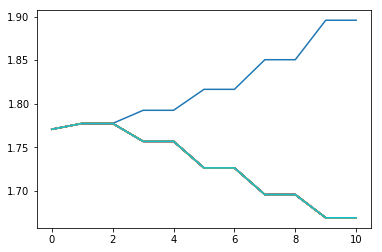

In [14]:
#Demonstrating the convergence properties in terms of iLQR iterations
for i in range(20):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=i+1,N=10)
    plt.plot(np.array(thetas)[:,0])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add


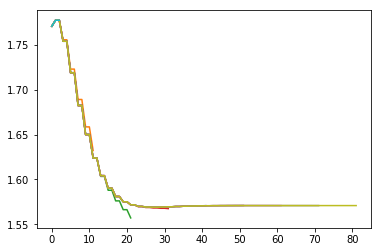

In [8]:
#Deomnstrating the convergence properties in terms of lookahead
for i in range(10):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=200,N=10*i+1)
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in add


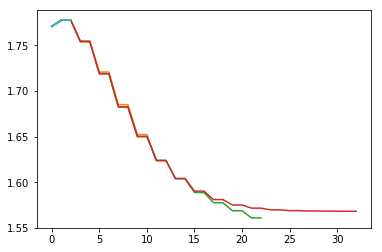

In [9]:
#Deomnstrating the convergence properties in terms of lookahead
thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+0.2,0.2]), iters=200,N=2)
for i in range(10):
    thetas, ass, Ks, ks = iLQR(np.array([np.pi/2+0.2,0.2]), iters=200,N=10*i+2, Ks=Ks, ks=ks)
    for j in range(10):
        Ks.append(Ks[-2])
        ks.append(ks[-2])
    plt.plot(np.array(thetas)[:,0])
    #print(Ks)

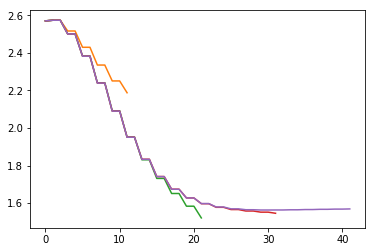

In [15]:
#Deomnstrating the convergence properties in terms of lookahead
for i in range(5):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+1.0,0.1]), iters=105,N=10*i+1)
    plt.plot(np.array(thetas)[:,0])


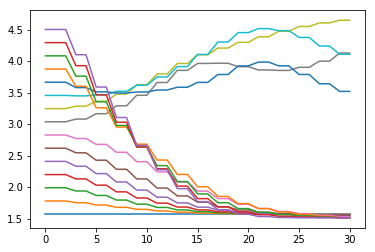

In [12]:
#Deomnstrating the convergence properties in terms perturbation from stable position
for i in range(15):
    thetas, ass, Ks, ks, = iLQR(np.array([np.pi/2+np.pi/15 * i,0.0]), iters=15,N=30)
    plt.plot(np.array(thetas)[:,0])
#print(Ks)
#print(ass)

That's kind of curious behavior. There is an area where it doesn't know what to do really but then it comes back. It kind of makes sense.